# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions,InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

# Reading files

# Generating new images 

In [3]:
train_dir = '/kaggle/input/birds-20-species-image-classification/train'
test_dir = '/kaggle/input/birds-20-species-image-classification/test'
val_dir = '/kaggle/input/birds-20-species-image-classification/valid'


class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)

Class names: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL']


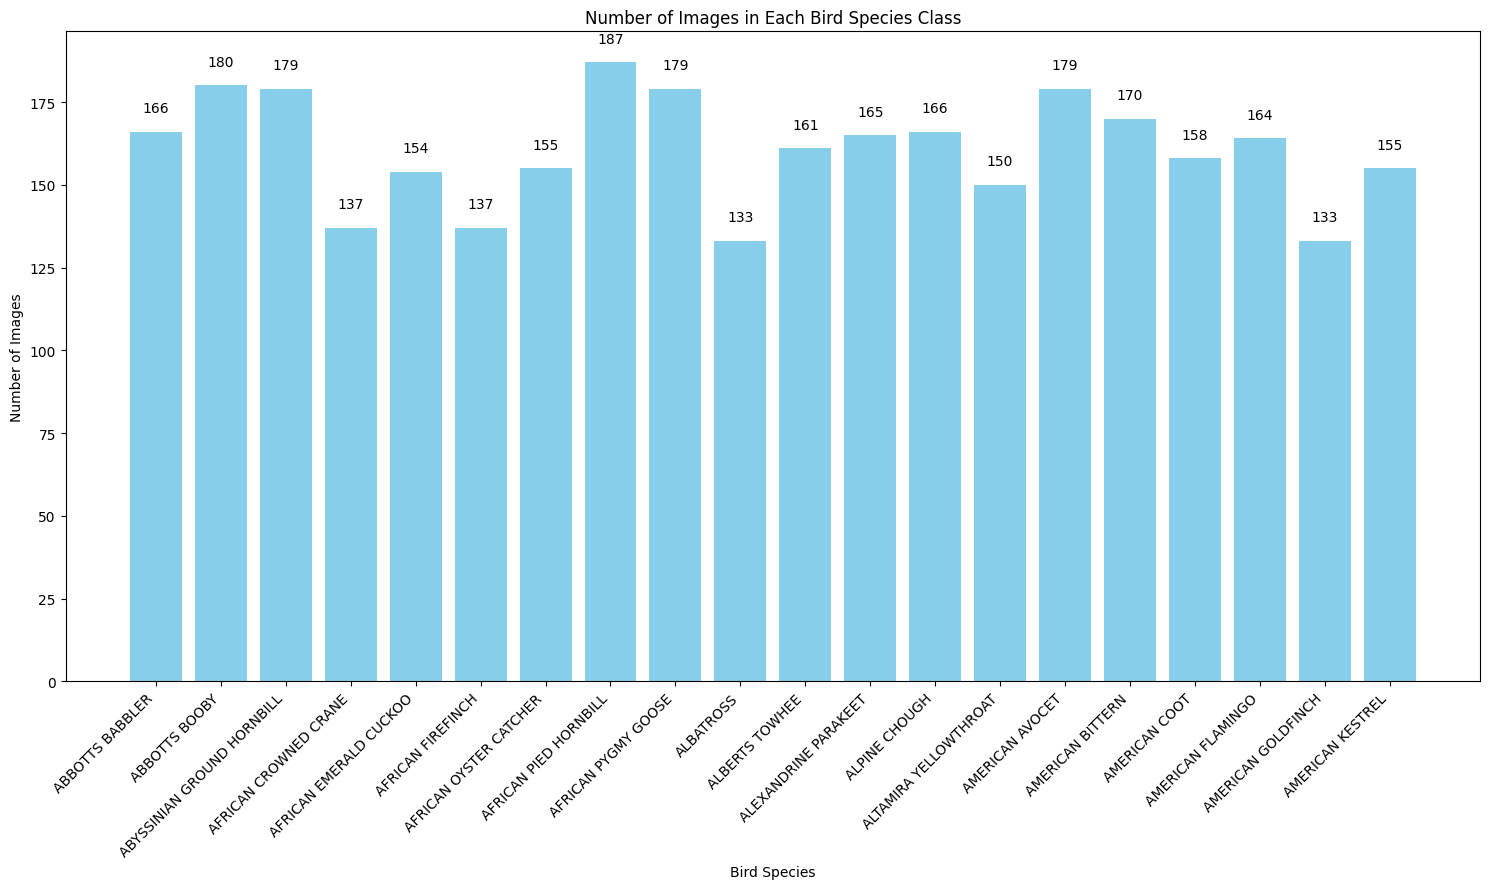

In [4]:
class_count = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    class_count[class_name] = num_images

# Plot the bar chart with labels
plt.figure(figsize=(15, 9))
bars = plt.bar(class_count.keys(), class_count.values(), color='skyblue')
plt.xlabel('Bird Species')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Bird Species Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the number of images on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [5]:
#  for class_name, num_images in class_count.items():
#     print(f"{class_name}: {num_images} images")

In [51]:
def imread(path):
    return cv2.imread(path)

def imwrite(img,path):
    if cv2.imread(path,img):
        print("image saved to '{}'".format(path))
    else:
        print("faild to save")
        
def imshow(img,figsize=(10,10),is_bgr=True):
    if is_bgr:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img,cmap='gray')
    plt.show() 

In [7]:
! pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/ad/1e/62ed77dbb887a963c788c61dc6e740c1d16462fcdd37acf247099f1a911b/ultralytics-8.0.229-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 11.5 MB/s eta 0:00:00a 0:00:01


In [8]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5310.6/8062.4 GB disk)


In [9]:
from ultralytics import YOLO

In [10]:
yolo_model=YOLO('model/yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 22.4MB/s]


In [21]:
yolo_model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [22]:
for i in yolo_model.names:
    if yolo_model.names[i] == "bird" :
        print(i)

14


In [12]:
yolo_test_img=imread("/kaggle/input/birds-20-species-image-classification/images to predict/5.jpg")

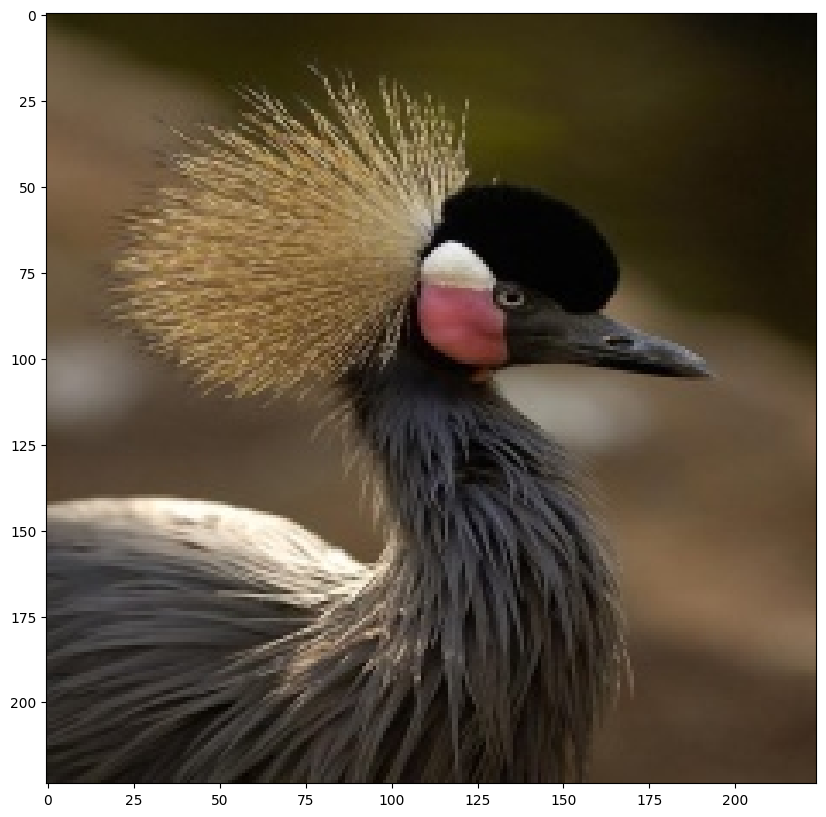

In [13]:
imshow(yolo_test_img)

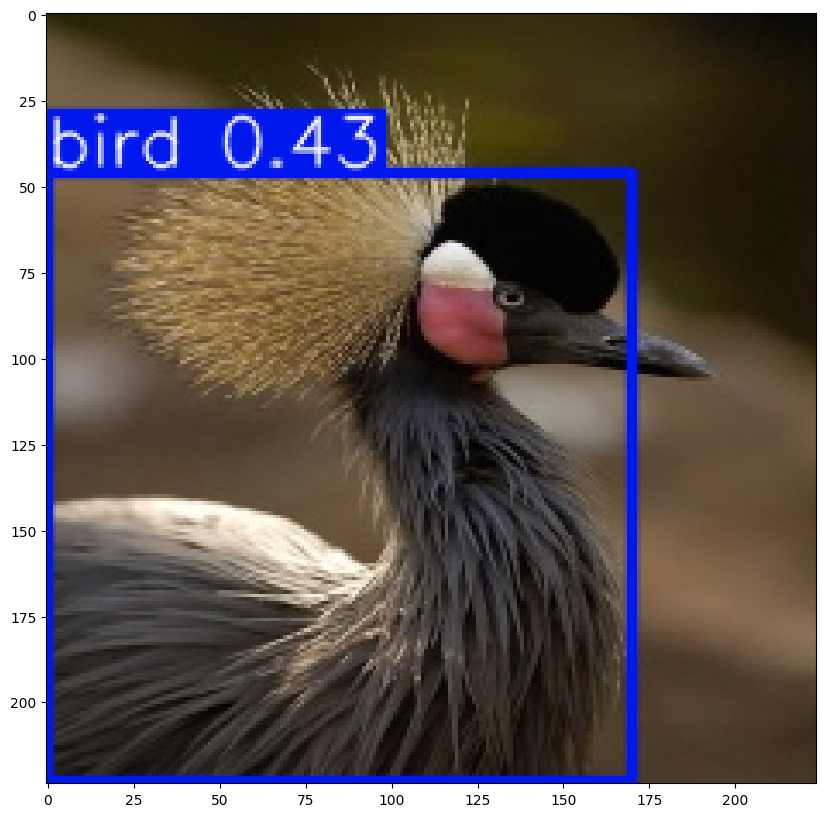

In [23]:

result=yolo_model.predict(yolo_test_img,verbose=False ,classes=[14])
result=result[0]
result_img=result.plot()
imshow(result_img)


In [17]:
for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    print("Object type:", class_id)
    print("Coordinates:", cords)
    print("Probability:", conf)
    print("---")

Object type: bird
Coordinates: [0, 46, 171, 224]
Probability: 0.43
---


In [70]:
def yolo_and_model_prediction (img_path):
    img = cv2.imread(img_path)
    
    result=yolo_model.predict(img_path,verbose=False ,classes=[14])
    result=result[0]
    result_img=result.plot()
    imshow(result_img)
    print("###########################")
    for box in result.boxes:
        class_id = result.names[box.cls[0].item()]
        cords = box.xyxy.flatten().tolist()
        cords = [round(x) for x in cords]
        conf = round(box.conf[0].item(), 2)
        
        print("Object type:", class_id)
        print("Coordinates:", cords)
        print("Probability:", conf)
        
        #plot the cropped objects 
        (x1, y1, x2, y2) = cords
        plt.imshow(img[y1:y2, x1:x2])
#       plt.figure(figsize=(2, 2))
        plt.show()
        
        print("_____________________________")
        

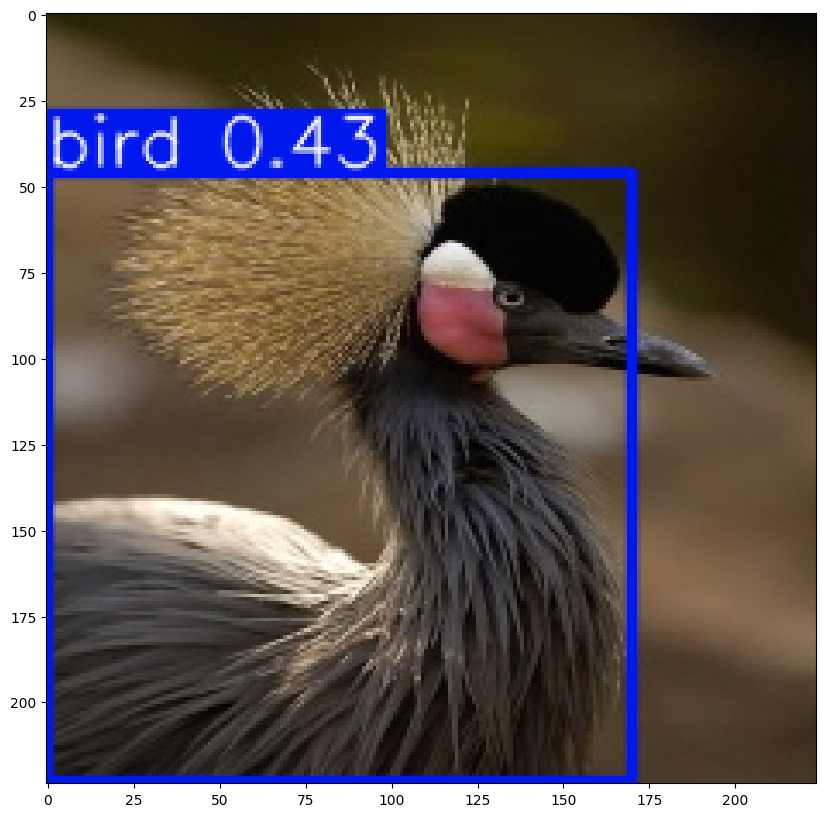

###########################
Object type: bird
Coordinates: [0, 46, 171, 224]
Probability: 0.43


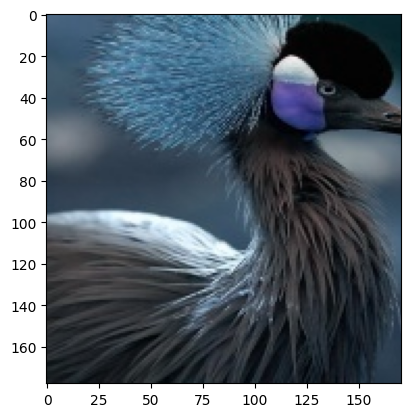

_____________________________


In [71]:
yolo_and_model_prediction("/kaggle/input/birds-20-species-image-classification/images to predict/5.jpg")

In [15]:
img_size=224
batch_size=64

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)


valid_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


# Making the Model

In [4]:
model = InceptionV3(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

# Make all the layers in the pre-trained model non-trainable
for layer in model.layers:
    layer.trainable = False

# Print the model summary
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [5]:
last_layer = model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(20, activation='softmax')(x)           

model = Model(model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

last layer output shape:  (None, 12, 12, 768)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32

# Fine Tuning

In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)


# model_checkpoint = ModelCheckpoint(filepath='best_weights.h5',
#                                    monitor='val_loss',
#                                    verbose=1,
#                                    save_best_only=True,
#                                    mode='max')


# Training the model

In [8]:
epochs=10

history = model.fit(train_generator, epochs=epochs,batch_size=batch_size, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/10
51/51 [==============================] - 59s 1s/step - loss: 2.0796 - accuracy: 0.7067 - val_loss: 0.5679 - val_accuracy: 0.8200
Epoch 2/10
51/51 [==============================] - 39s 784ms/step - loss: 0.5033 - accuracy: 0.8725 - val_loss: 0.1006 - val_accuracy: 0.9700
Epoch 3/10
51/51 [==============================] - 39s 761ms/step - loss: 0.2789 - accuracy: 0.9233 - val_loss: 0.2321 - val_accuracy: 0.9300
Epoch 4/10
51/51 [==============================] - 38s 752ms/step - loss: 0.2621 - accuracy: 0.9349 - val_loss: 0.3294 - val_accuracy: 0.9300
Epoch 5/10
51/51 [==============================] - 39s 760ms/step - loss: 0.1509 - accuracy: 0.9536 - val_loss: 0.1231 - val_accuracy: 0.9300
Epoch 6/10
51/51 [==============================] - 39s 770ms/step - loss: 0.1302 - accuracy: 0.9663 - val_loss: 0.0179 - val_accuracy: 0.9900
Epoch 7/10
51/51 [==============================] - 38s 752ms/step - loss: 0.1443 - accuracy: 0.9654 - val_loss: 0.0314 - val_accuracy: 0.9900
Ep

# Visualizing The Loss & Accuracy Curves


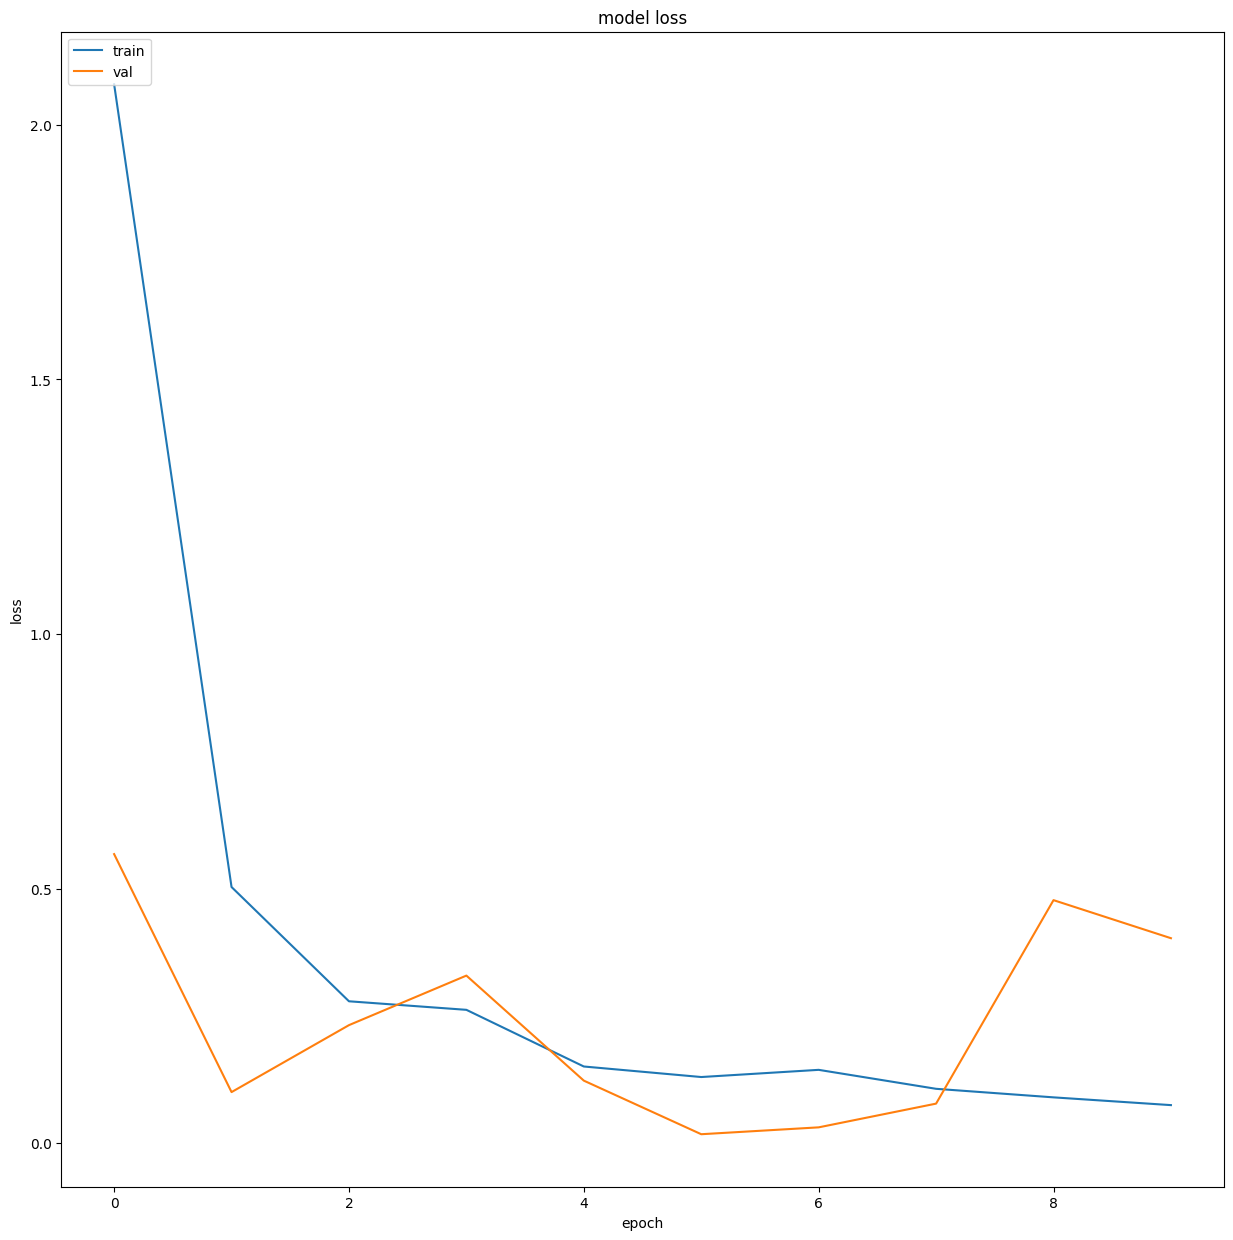

In [30]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

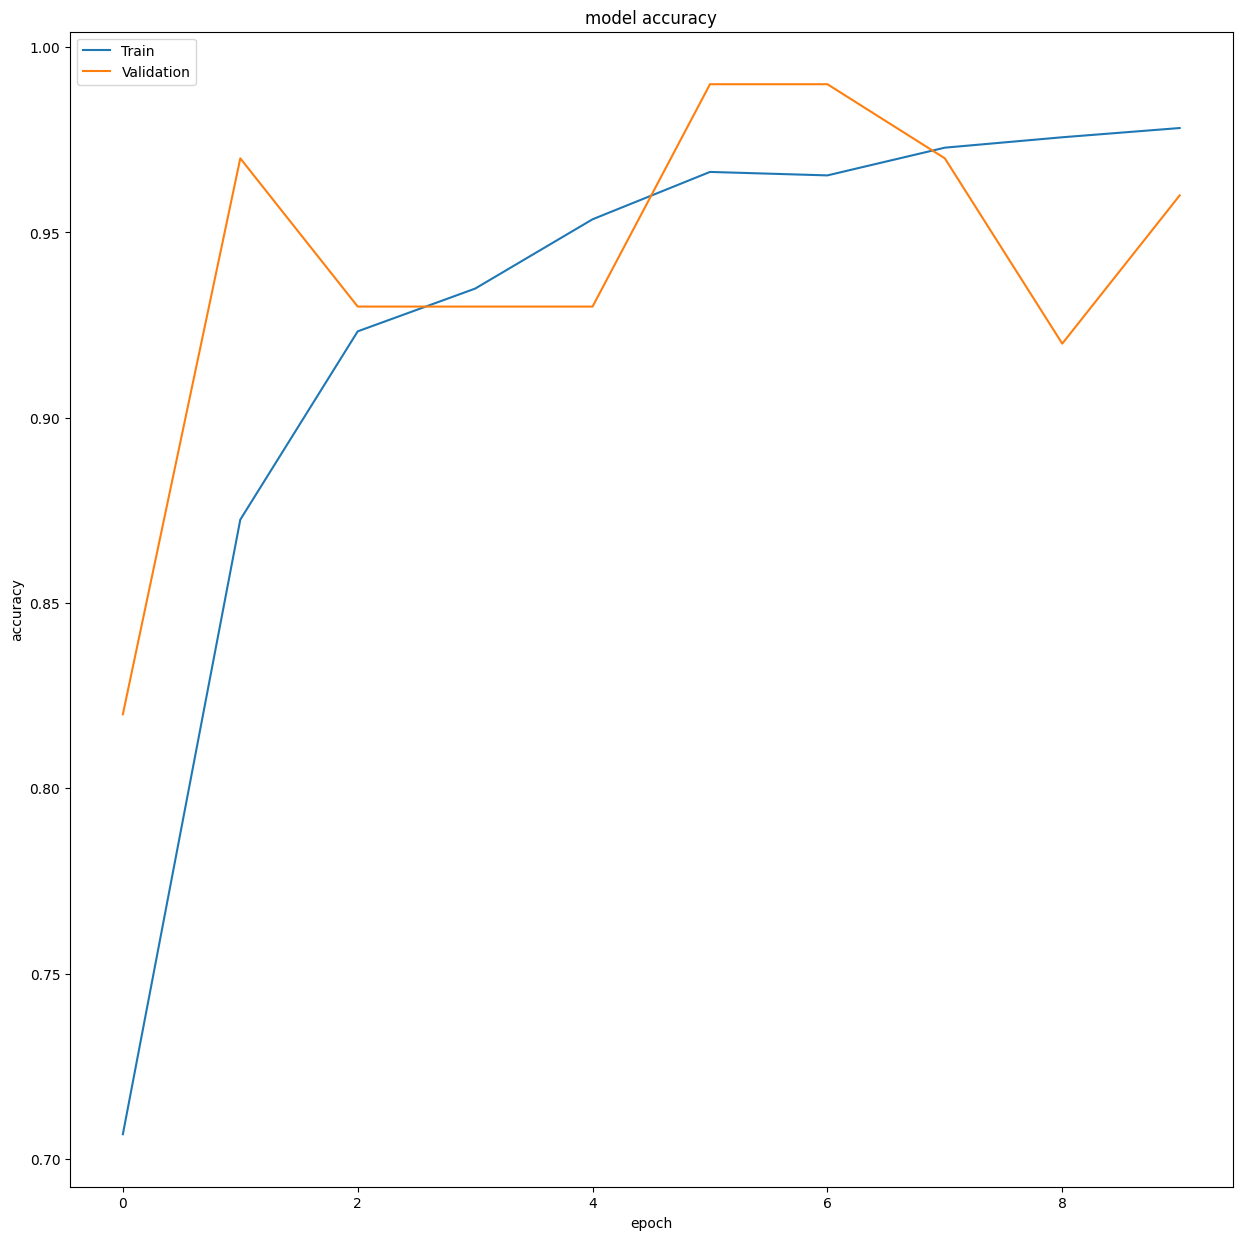

In [31]:
plt.figure(figsize=(15,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Saving the model

In [32]:
model.save('/kaggle/working/Models/model.h5')
print("saved")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


saved


# Making The prediction 

In [33]:
bird_dictionary = {
    0: 'ABBOTTS BABBLER',
    1: 'ABBOTTS BOOBY',
    2: 'ABYSSINIAN GROUND HORNBILL',
    3: 'AFRICAN CROWNED CRANE',
    4: 'AFRICAN EMERALD CUCKOO',
    5: 'AFRICAN FIREFINCH',
    6: 'AFRICAN OYSTER CATCHER',
    7: 'AFRICAN PIED HORNBILL',
    8: 'AFRICAN PYGMY GOOSE',
    9: 'ALBATROSS',
    10: 'ALBERTS TOWHEE',
    11: 'ALEXANDRINE PARAKEET',
    12: 'ALPINE CHOUGH',
    13: 'ALTAMIRA YELLOWTHROAT',
    14: 'AMERICAN AVOCET',
    15: 'AMERICAN BITTERN',
    16: 'AMERICAN COOT',
    17: 'AMERICAN FLAMINGO',
    18: 'AMERICAN GOLDFINCH',
    19: 'AMERICAN KESTREL'
}


In [34]:
img_path='/kaggle/input/birds-20-species-image-classification/images to predict/1.jpg'

In [43]:
def predict_dir(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))  
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    preprocessed_img = preprocess_input(img_array) 

    predictions = model.predict(preprocessed_img)  
    
    predicted_class_index = np.argmax(predictions)
    bird_name = bird_dictionary[predicted_class_index]
    print(bird_name)
    

In [44]:
predict_dir(img_path)

1/1 [==============================] - 0s 25ms/step
AFRICAN CROWNED CRANE
